# Evaluate agent

The following notebook can be used to train the RL agents and evaluate policies produced by the trained agents.

In [5]:
import sac_tri_envs_dis, sac_tri
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib
import matplotlib.pyplot as plt

/opt/anaconda3/envs/rl_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Load the agent.

The following cell loads a pretrained RL agent and generates data useful for future plots.

In [33]:
LOG_DIR = "data/adaptive_a=1.0_k=0.90"
#LOG_DIR = "data/X_a=1.0_k=0.55"

ADAPTIVE_MEASUREMENT = True # Mark as TRUE to make the plots suitable for adaptive measurement

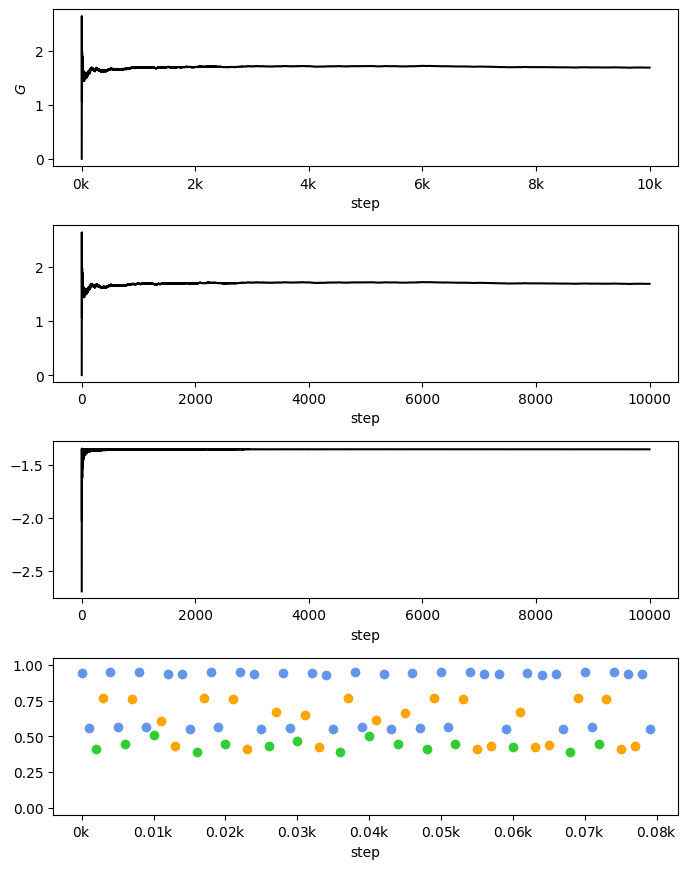

In [25]:


# Check if LOG_DIR describes the adaptive measurement
if "meas_angle" in LOG_DIR or "penalty_influence" in LOG_DIR:
    adaptive_measurement = True
else:
    adaptive_measurement = False

loaded_train = sac_tri.SacTrain()
loaded_train.load_train(LOG_DIR, no_train=True)
#evaluate the deterministic policy
_, _, info = loaded_train.evaluate_current_policy(deterministic=True, steps=10000, gamma=0.9999,actions_to_plot=80,
                                      save_policy_to_file_name="det_policy.txt",actions_ylim=[-0.05,1.05])

# Create a list of colors useful for plots later
colors = []
for idx, d_act in enumerate(info["discrete_actions"]):
    if d_act == 0:
        colors.append("orange")
    elif d_act == 1:
        if adaptive_measurement:
            theta = info["continuous_actions"][idx] * 3.6 - 0.2
            red_col = np.sin(theta)**2 
            blue_col = np.cos(theta)**2 
            colors.append( (red_col, 0.0, blue_col) )
        else:
            colors.append("cornflowerblue")
    elif d_act == 2:
        colors.append("limegreen")

if adaptive_measurement:
    #Plot legend with discrete elements
    legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Thermalization',
                          markerfacecolor='orange', markersize=10),
                       matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Feedback',
                          markerfacecolor='limegreen', markersize=10)]
else: 
    legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Thermalization',
                          markerfacecolor='orange', markersize=10),
                       matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Measurement',
                          markerfacecolor='cornflowerblue', markersize=10),
                       matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Feedback',
                          markerfacecolor='limegreen', markersize=10)] 

# 2. RL agent - single run visualization

In this section we perform a single run of the trained RL agent and plot resulting policy.

The following cell generates a plot in style of Fig. 5 in the paper.

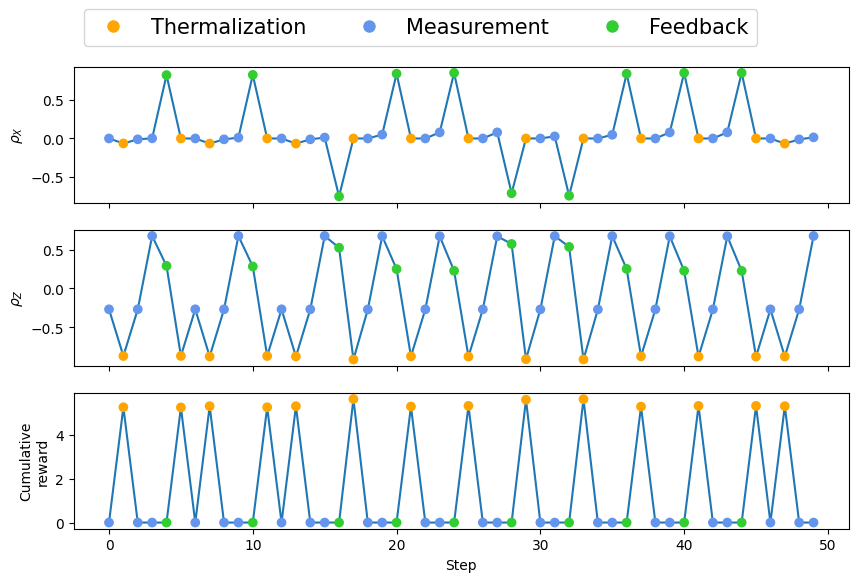

In [27]:
STEPS_TO_PLOT = 50

# Lists to store Bloch coordinates
X_s, Z_s = info["rhofx"], info["rhofz"]

if adaptive_measurement:
    image = matplotlib.image.imread("adaptive_measurement_colorbar.png")
    plt.imshow(image)
    plt.axis(False)

fig, axs = plt.subplots(nrows = 3, ncols = 1, sharex = True, figsize = (10,6))
axs[0].plot(range(STEPS_TO_PLOT), X_s[:STEPS_TO_PLOT], zorder = 0)
axs[0].scatter(range(STEPS_TO_PLOT), X_s[:STEPS_TO_PLOT], c = colors[:STEPS_TO_PLOT], zorder = 1)
axs[0].set_ylabel(r"$\rho_X$")
axs[0].legend(handles=legend_elements, fontsize = 15, ncols = len(legend_elements),
                loc = "upper left", facecolor = "white", framealpha = 0.8,
                 bbox_to_anchor=(0.0, 1.50))

axs[1].plot(range(STEPS_TO_PLOT), Z_s[:STEPS_TO_PLOT], zorder = 0)
axs[1].scatter(range(STEPS_TO_PLOT), Z_s[:STEPS_TO_PLOT], c = colors[:STEPS_TO_PLOT], zorder = 1)
axs[1].set_ylabel(r"$\rho_Z$")

axs[2].plot(range(STEPS_TO_PLOT), info["rewards"][:STEPS_TO_PLOT], zorder = 0)
axs[2].scatter(range(STEPS_TO_PLOT), info["rewards"][:STEPS_TO_PLOT], c = colors[:STEPS_TO_PLOT], zorder = 1)
axs[2].set_ylabel("Cumulative\nreward")
axs[2].set_xlabel("Step")

plt.show()

**Bloch plane plot**

The cell below generates the plots in style of Fig.4 in the paper. 

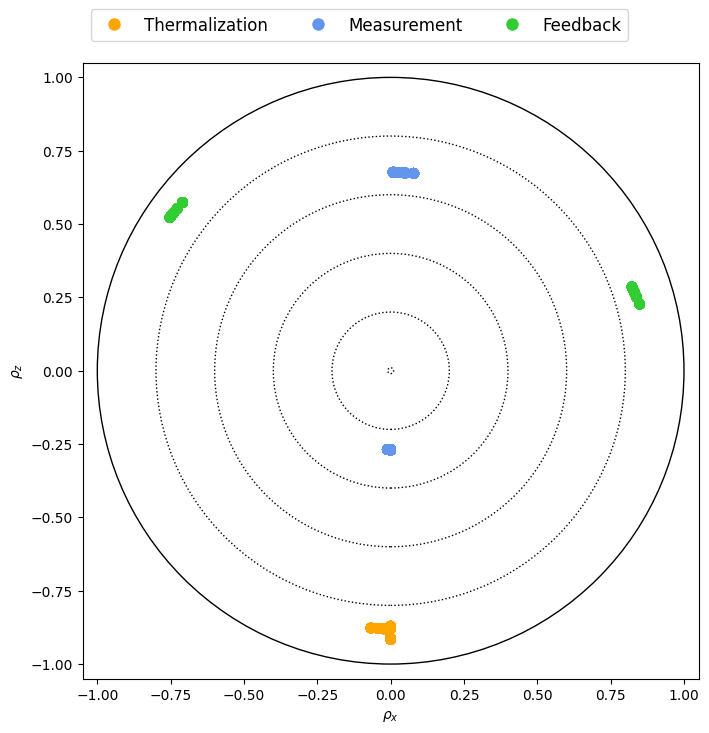

In [31]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))

r1 = plt.Circle( (0.0, 0.0 ), 1.0 , fill = False )
r08 = plt.Circle( (0.0, 0.0 ), 0.8 , fill = False , linestyle = ":")
r06 = plt.Circle( (0.0, 0.0 ), 0.6 , fill = False , linestyle = ":")
r04 = plt.Circle( (0.0, 0.0 ), 0.4 , fill = False , linestyle = ":")
r02 = plt.Circle( (0.0, 0.0 ), 0.2 , fill = False , linestyle = ":")
r0  = plt.Circle( (0.0, 0.0 ), 0.01 , fill = False , linestyle = ":")
circle_list = [ r0, r02, r04, r06, r08, r1 ]
for r in circle_list:
    axs.add_artist( r )
# Plot properties
axs.set_aspect( 1 ) #Aspect ratio 
axs.set_xlim( -1.05, 1.05 )
axs.set_ylim( -1.05, 1.05 )
axs.set_xlabel(r"$\rho_x$")
axs.set_ylabel(r"$\rho_z$")
axs.legend(handles=legend_elements, fontsize = 12, ncols = len(legend_elements),
                loc = "upper left", facecolor = "white", framealpha = 0.8,
                 bbox_to_anchor=(0.0, 1.1))

axs.scatter(X_s[50:-1], Z_s[50:-1], c = colors[50:], alpha = 0.10, s = 45)